In [1]:
import os
import warnings
import regex as re
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
import scipy
import implicit
import bisect
from functools import reduce
import sklearn.metrics as m
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split

os.environ['OPENBLAS_NUM_THREADS'] = '1'
warnings.filterwarnings('ignore')

In [2]:
LOCAL_DATA_PATH = './context_data/'
SPLIT_SEED = 42
DATA_FILE = 'competition_data_final_pqt'
TARGET_FILE = 'public_train.pqt'
SUBMISSION_FILE = 'submit_2.pqt'
FEATURES = './features'

part10 = "part-00009-aba60f69-2b63-4cc1-95ca-542598094698-c000.snappy.parquet"

In [3]:
id_to_submit = pq.read_table(f'{LOCAL_DATA_PATH}/{SUBMISSION_FILE}').to_pandas()

In [3]:
data = pq.read_table(f'{LOCAL_DATA_PATH}/{DATA_FILE}')
# data['date'] = data['date'].apply(lambda x: x.weekday())

In [13]:
targets = pq.read_table(f'{LOCAL_DATA_PATH}/{TARGET_FILE}')

In [4]:
%%time
data_agg = data.select(['user_id', 'url_host', 'request_cnt']).\
    group_by(['user_id', 'url_host']).aggregate([('request_cnt', "sum")])

CPU times: user 39.6 s, sys: 29.9 s, total: 1min 9s
Wall time: 1min 42s


In [79]:
%%time
data_agg = data[['user_id', 'url_host', 'date', 'part_of_day', 'request_cnt']].groupby(['user_id', 'url_host', 'date', 'part_of_day']).agg({'request_cnt': 'sum'}).unstack(level=-1)

CPU times: user 20.2 s, sys: 5.72 s, total: 25.9 s
Wall time: 26 s


In [80]:
data_agg_dow_nig = data_agg.request_cnt['night'].unstack(level=-1)
data_agg_dow_mor = data_agg.request_cnt['morning'].unstack(level=-1)
data_agg_dow_day = data_agg.request_cnt['day'].unstack(level=-1)
data_agg_dow_eve = data_agg.request_cnt['evening'].unstack(level=-1)

In [81]:
data_agg_dow_nig_reset = data_agg_dow_nig.reset_index()
data_agg_dow_mor_reset = data_agg_dow_mor.reset_index()
data_agg_dow_day_reset = data_agg_dow_day.reset_index()
data_agg_dow_eve_reset = data_agg_dow_eve.reset_index()

In [82]:
data_agg_dow_nig_reset_gb = data_agg_dow_nig_reset.groupby('user_id').agg({0: "std", 1: "std", 2: 'std', 3: 'std', 4: 'std', 5: 'std', 6: 'std'})
data_agg_dow_mor_reset_gb = data_agg_dow_mor_reset.groupby('user_id').agg({0: "std", 1: "std", 2: 'std', 3: 'std', 4: 'std', 5: 'std', 6: 'std'})
data_agg_dow_day_reset_gb = data_agg_dow_day_reset.groupby('user_id').agg({0: "std", 1: "std", 2: 'std', 3: 'std', 4: 'std', 5: 'std', 6: 'std'})
data_agg_dow_eve_reset_gb = data_agg_dow_eve_reset.groupby('user_id').agg({0: "std", 1: "std", 2: 'std', 3: 'std', 4: 'std', 5: 'std', 6: 'std'})

In [83]:
data_agg_dow_nig_reset_gb=data_agg_dow_nig_reset_gb.fillna(-1)
data_agg_dow_mor_reset_gb= data_agg_dow_mor_reset_gb.fillna(-1)
data_agg_dow_day_reset_gb= data_agg_dow_day_reset_gb.fillna(-1)
data_agg_dow_eve_reset_gb= data_agg_dow_eve_reset_gb.fillna(-1)


In [85]:
data_agg_dow_nig_reset_gb.reset_index().to_csv('data10_nig_std.csv')
data_agg_dow_mor_reset_gb.reset_index().to_csv('data10_mor_std.csv')
data_agg_dow_day_reset_gb.reset_index().to_csv('data10_day_std.csv')
data_agg_dow_eve_reset_gb.reset_index().to_csv('data10_eve_std.csv')

In [84]:
data_agg_dow_nig_reset_gb.reset_index()

date,user_id,0,1,2,3,4,5,6
0,1,0.500000,1.414214,0.000000,0.577350,0.500000,-1.000000,0.000000
1,9,-1.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
2,21,2.609372,1.444500,1.964555,2.416609,1.973787,1.370320,1.696787
3,22,1.224745,0.408248,0.836660,0.000000,0.809040,0.744024,0.377964
4,37,0.500000,3.562430,3.494894,-1.000000,2.898275,1.996708,2.855086
...,...,...,...,...,...,...,...,...
41554,415287,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
41555,415289,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
41556,415295,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
41557,415310,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000


In [98]:
files = [file for file in sorted(os.listdir()) if re.match('data\d{1,2}_day',file) ]
data_eve_sum = pd.DataFrame()
df = pd.concat(map(pd.read_csv, files))


In [100]:
df.sort_values(by=['user_id']).drop('Unnamed: 0', axis=1).to_csv('data_day_std.csv')

In [101]:
pd.read_csv('data_day_std.csv')

,Unnamed: 0,user_id,0,1,2,3,4,5,6
0,0,0,-1.000000,1.436800,0.646670,-1.000000,0.577350,0.000000,0.000000
1,0,1,3.958853,3.614784,2.153586,1.586086,1.302573,1.770122,2.007130
2,0,2,1.245946,0.351866,0.897451,1.035725,1.147079,1.418136,1.200490
3,0,3,1.224745,1.602082,1.864454,0.577350,1.114641,0.534522,0.543906
4,0,4,1.460894,0.816497,1.295897,1.032796,1.391941,0.558796,0.904534
...,...,...,...,...,...,...,...,...,...
415312,41611,415312,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
415313,41569,415313,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
415314,41682,415314,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
415315,41460,415315,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000


In [5]:
url_set = set(data_agg.select(['url_host']).to_pandas()['url_host'])
print(f'{len(url_set)} urls')
url_dict = {url: idurl for url, idurl in zip(url_set, range(len(url_set)))}
usr_set = set(data_agg.select(['user_id']).to_pandas()['user_id'])
print(f'{len(usr_set)} users')
usr_dict = {usr: user_id for usr, user_id in zip(usr_set, range(len(usr_set)))}

199683 urls
415317 users


In [6]:
features = pd.read_csv('features.csv')
# usr_n_cities = pd.read_csv(f"{FEATURES}/usr_n_cities.csv").drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)
# usr_prt_of_day = pd.read_csv(f"{FEATURES}/usr_prt_of_day.csv").drop(['Unnamed: 0'], axis=1)
# usr_request_cnt_sum = pd.read_csv(f"{FEATURES}/usr_request_cnt_sum.csv").drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)
# usr_is_apple = pd.read_csv(f"{FEATURES}/usr_is_apple.csv").drop('Unnamed: 0', axis=1)
# usr_url_rf_idf = pd.read_csv(f"{FEATURES}/usr_url_tf_idf.csv").drop('Unnamed: 0', axis=1)
# usr_url_count_max_diff = pd.read_csv(f"{FEATURES}/usr_url_count_max_diff.csv").drop('Unnamed: 0', axis=1)
#
# data_day_count = pd.read_csv(f"{FEATURES}/data_day_count.csv").drop('Unnamed: 0', axis=1)
# data_day_mean = pd.read_csv(f"{FEATURES}/data_day_mean.csv").drop('Unnamed: 0', axis=1)
# data_day_median = pd.read_csv(f"{FEATURES}/data_day_median.csv").drop('Unnamed: 0', axis=1)
# data_day_std = pd.read_csv(f"{FEATURES}/data_day_std.csv").drop('Unnamed: 0', axis=1)
# data_day_sum = pd.read_csv(f"{FEATURES}/data_day_sum.csv").drop('Unnamed: 0', axis=1)
# data_day_var = pd.read_csv(f"{FEATURES}/data_day_var.csv").drop('Unnamed: 0', axis=1)
#
# data_eve_count = pd.read_csv(f"{FEATURES}/data_eve_count.csv").drop('Unnamed: 0', axis=1)
# data_eve_mean = pd.read_csv(f"{FEATURES}/data_eve_mean.csv").drop('Unnamed: 0', axis=1)
# data_eve_median = pd.read_csv(f"{FEATURES}/data_eve_median.csv").drop('Unnamed: 0', axis=1)
# data_eve_std = pd.read_csv(f"{FEATURES}/data_eve_std.csv").drop('Unnamed: 0', axis=1)
# data_eve_sum = pd.read_csv(f"{FEATURES}/data_eve_sum.csv").drop('Unnamed: 0', axis=1)
# data_eve_var = pd.read_csv(f"{FEATURES}/data_eve_var.csv").drop('Unnamed: 0', axis=1)
#
# data_mor_count = pd.read_csv(f"{FEATURES}/data_mor_count.csv").drop('Unnamed: 0', axis=1)
# data_mor_mean = pd.read_csv(f"{FEATURES}/data_mor_mean.csv").drop('Unnamed: 0', axis=1)
# data_mor_median = pd.read_csv(f"{FEATURES}/data_mor_median.csv").drop('Unnamed: 0', axis=1)
# data_mor_std = pd.read_csv(f"{FEATURES}/data_mor_std.csv").drop('Unnamed: 0', axis=1)
# data_mor_sum = pd.read_csv(f"{FEATURES}/data_mor_sum.csv").drop('Unnamed: 0', axis=1)
# data_mor_var = pd.read_csv(f"{FEATURES}/data_mor_var.csv").drop('Unnamed: 0', axis=1)
#
# data_nig_count = pd.read_csv(f"{FEATURES}/data_nig_count.csv").drop('Unnamed: 0', axis=1)
# data_nig_mean = pd.read_csv(f"{FEATURES}/data_nig_mean.csv").drop('Unnamed: 0', axis=1)
# data_nig_median = pd.read_csv(f"{FEATURES}/data_nig_median.csv").drop('Unnamed: 0', axis=1)
# data_nig_std = pd.read_csv(f"{FEATURES}/data_nig_std.csv").drop('Unnamed: 0', axis=1)
# data_nig_sum = pd.read_csv(f"{FEATURES}/data_nig_sum.csv").drop('Unnamed: 0', axis=1)
# data_nig_var = pd.read_csv(f"{FEATURES}/data_nig_var.csv").drop('Unnamed: 0', axis=1)
#
# data_frames = [usr_n_cities, usr_prt_of_day, usr_request_cnt_sum, usr_is_apple, usr_url_rf_idf, usr_url_count_max_diff,data_nig_count, data_nig_mean, data_nig_median,data_nig_std, data_nig_sum,data_nig_var, data_mor_count, data_mor_mean, data_mor_median,data_mor_std, data_mor_sum,data_mor_var, data_day_count, data_day_mean, data_day_median,data_day_std, data_day_sum,data_day_var, data_eve_count, data_eve_mean, data_eve_median,data_eve_std, data_eve_sum,data_eve_var    ]
#
# df_merged = reduce(lambda left, right: pd.merge(left, right, on=['user_id'],
#                                                 how='outer'), data_frames)

In [129]:
df.columns = ['user_id', 'nig0_var', 'nig1_var', 'nig2_var', 'nig3_var', 'nig4_var', 'nig5_var', 'nig6_var']

In [131]:
df.to_csv('./features/data_nig_var.csv')

In [8]:
%%time
values = np.array(data_agg.select(['request_cnt_sum']).to_pandas()['request_cnt_sum'])
rows = np.array(data_agg.select(['user_id']).to_pandas()['user_id'].map(usr_dict))
cols = np.array(data_agg.select(['url_host']).to_pandas()['url_host'].map(url_dict))
mat = scipy.sparse.coo_matrix((values, (rows, cols)), shape=(rows.max() + 1, cols.max() + 1))
als = implicit.approximate_als.FaissAlternatingLeastSquares(factors = 400, iterations = 50, use_gpu = False, \
       calculate_training_loss = False, regularization = 0.1)

CPU times: user 9.47 s, sys: 1.18 s, total: 10.6 s
Wall time: 12 s


In [9]:
%%time
# als.fit(mat)
u_factors = pd.read_csv('u_factors_factors1000_iter50.csv')
d_factors = pd.read_csv('d_factors_factors1000_iter50.csv')

CPU times: user 1min 18s, sys: 13.1 s, total: 1min 31s
Wall time: 1min 36s


а## Получим оценку по полу

In [14]:
%%time
inv_usr_map = {v: k for k, v in usr_dict.items()}
usr_emb = pd.DataFrame(u_factors)
usr_emb['user_id'] = usr_emb.index.map(inv_usr_map)
usr_targets = targets.to_pandas()
df = usr_targets.merge(usr_emb, how='inner', on=['user_id'])
df = df[df['is_male'] != 'NA']
df = df.dropna()
df['is_male'] = df['is_male'].map(int)
df['is_male'].value_counts()

CPU times: user 8.1 s, sys: 8.4 s, total: 16.5 s
Wall time: 21.3 s


1    135331
0    128994
Name: is_male, dtype: int64

In [16]:
# usr_emb = usr_emb.drop('Unnamed: 0', axis=1)
df = df.drop('Unnamed: 0', axis=1)

In [18]:
df = df.merge(features, how='inner', on='user_id')

In [20]:
df = df.drop('Unnamed: 0', axis=1)

In [18]:
df.iloc[:,3:-1] = df.iloc[:,3:-1].apply(lambda x: (x-x.mean())/ x.std(), axis=0)

In [44]:
df = df.drop(['Unnamed: 0'], axis=1)

In [68]:

for i in df.columns:
    if 'var' in i or 'std' in i:
        df = df.drop(i, axis=1)


In [69]:
df

,age,is_male,user_id,0,1,2,3,4,5,6,...,eve4_median,eve5_median,eve6_median,eve0_sum,eve1_sum,eve2_sum,eve3_sum,eve4_sum,eve5_sum,eve6_sum
0,2,1,350459,0.079127,-0.261337,-0.054777,-0.063841,0.149612,0.144093,0.139705,...,1.0,1.0,0.0,5.0,5.0,9.0,0.0,8.0,3.0,0.0
1,2,1,188276,0.090250,-0.194692,-0.021347,-0.080565,0.082654,0.060838,0.154726,...,2.0,1.0,1.5,11.0,3.0,0.0,14.0,15.0,4.0,10.0
2,3,0,99002,0.080199,-0.444354,-0.455195,-0.172445,0.111503,0.207200,0.346973,...,1.0,1.0,1.0,57.0,35.0,35.0,21.0,51.0,26.0,36.0
3,2,0,155506,0.010592,-0.085335,-0.018836,-0.037221,-0.024121,0.266479,0.197777,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0,213873,-0.001455,-0.036098,0.005081,-0.004112,0.015231,0.013271,0.021005,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264320,4,1,225374,-0.030484,-0.606895,-0.802419,-0.229358,0.505762,-0.224237,0.160950,...,2.0,1.0,2.0,152.0,168.0,60.0,147.0,99.0,97.0,93.0
264321,1,1,25776,0.050839,-0.096067,0.025941,-0.050459,0.095747,-0.108858,0.197344,...,2.0,1.5,1.0,15.0,9.0,3.0,7.0,12.0,13.0,8.0
264322,2,0,148131,-0.032410,-0.161611,-0.130804,-0.059544,0.056275,0.286979,0.020047,...,1.0,2.0,2.0,21.0,10.0,5.0,18.0,4.0,24.0,13.0
264323,2,1,205570,0.206613,-0.371708,-0.387142,-0.044742,0.210821,-0.018112,0.154873,...,1.0,2.0,1.5,28.0,18.0,21.0,11.0,55.0,28.0,25.0


In [70]:
params = {
    'iterations': 20000,
        'learning_rate': 0.05,
          'early_stopping_rounds': 10,
          'verbose': 200,


          }
# depth=7, l2_leaf_reg=6, random_strength=5)

In [71]:
# ['user_id', 'age', 'is_male','request_cnt_sum', 'rating', 'usr_url_count_max_diff', 'is_apple']
x_train, x_test, y_train, y_test = train_test_split(
    df.drop(['user_id', 'is_male', 'age'], axis=1), df['is_male'], test_size=0.25)
clf = CatBoostClassifier(**params)
clf.fit(x_train, y_train, use_best_model=True, eval_set=[(x_test, y_test)])
print(f'GINI по полу {2 * m.roc_auc_score(y_test, clf.predict_proba(x_test)[:, 1]) - 1:2.3f}')

0:	learn: 0.6885821	test: 0.6886107	best: 0.6886107 (0)	total: 402ms	remaining: 2h 14m 7s
200:	learn: 0.5427225	test: 0.5469019	best: 0.5469019 (200)	total: 1m	remaining: 1h 39m 59s
400:	learn: 0.5122804	test: 0.5229983	best: 0.5229983 (400)	total: 1m 55s	remaining: 1h 34m 8s
600:	learn: 0.4941271	test: 0.5117377	best: 0.5117377 (600)	total: 2m 46s	remaining: 1h 29m 20s
800:	learn: 0.4804636	test: 0.5052096	best: 0.5052096 (800)	total: 3m 37s	remaining: 1h 27m 3s
1000:	learn: 0.4690206	test: 0.5005507	best: 0.5005507 (1000)	total: 4m 26s	remaining: 1h 24m 10s
1200:	learn: 0.4588904	test: 0.4973434	best: 0.4973434 (1200)	total: 5m 27s	remaining: 1h 25m 22s
1400:	learn: 0.4495592	test: 0.4948465	best: 0.4948465 (1400)	total: 6m 23s	remaining: 1h 24m 44s
1600:	learn: 0.4409489	test: 0.4929917	best: 0.4929917 (1600)	total: 7m 8s	remaining: 1h 22m 7s
1800:	learn: 0.4328623	test: 0.4913815	best: 0.4913815 (1800)	total: 8m 12s	remaining: 1h 22m 55s
2000:	learn: 0.4252508	test: 0.4900076	best:

In [32]:
id_to_submit = pq.read_table(f'{LOCAL_DATA_PATH}/{SUBMISSION_FILE}').to_pandas()

In [30]:
id_to_submit = id_to_submit.merge(df, how='inner', on='user_id')
# id_to_submit = id_to_submit.merge(usr_emb, how='inner', on='user_id')
# id_to_submit = id_to_submit.merge(features, how='inner', on='user_id')

In [45]:
id_to_submit = id_to_submit.merge(usr_emb, how='inner', on='user_id')
id_to_submit = id_to_submit.merge(features, how='inner', on='user_id')



In [47]:
id_to_submit = id_to_submit.drop(['Unnamed: 0_x', 'Unnamed: 0_y'], axis=1)

In [48]:

id_to_submit['is_male'] = clf.predict_proba(id_to_submit.drop('user_id', axis=1))[:, 1]

In [50]:
id_to_submit['is_male']

0         0.956952
1         0.547823
2         0.439849
3         0.620491
4         0.895488
            ...   
144719    0.524122
144720    0.524510
144721    0.540817
144722    0.562031
144723    0.541799
Name: is_male, Length: 144724, dtype: float64

## Получим оценку по возрасту

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

% matplotlib inline
sns.set_style('darkgrid')

UsageError: Line magic function `%` not found.


In [52]:
def age_bucket(x):
    return bisect.bisect_left([18, 25, 35, 45, 55, 65], x)

<AxesSubplot:xlabel='age', ylabel='Count'>

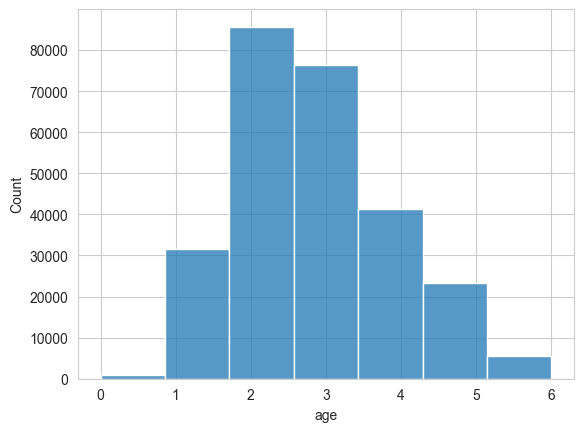

In [53]:
# df = usr_targets.merge(usr_emb, how='inner', on=['user_id'])
# df = df[df['age'] != 'NA']
# df = df.dropna()
df['age'] = df['age'].map(age_bucket)
sns.histplot(df['age'], bins=7)

In [33]:
id_to_submit

,0,1,2,3,4,5,6,7,8,9,...,n_cities,part_of_day_day,part_of_day_evening,part_of_day_morning,part_of_day_night,request_cnt_sum,is_apple,rating,usr_url_count_max_diff,is_male
0,0.191614,0.071623,-0.042019,-0.294404,0.122975,0.094562,0.131374,-0.060079,-0.251093,0.150594,...,1,1,0,0,0,193,0,0,39,0.124572
1,-0.040495,-0.258130,-0.259743,-0.106191,0.153784,-0.106545,0.266895,-0.181595,-0.552161,0.178150,...,6,1,0,0,0,1047,0,1,63,0.195605
2,0.116619,-0.486137,-0.267274,-0.048977,0.251495,0.000681,0.078965,-0.245788,-0.400401,0.162877,...,1,1,0,0,0,411,0,0,18,0.420153
3,-0.000366,-0.294002,-0.315874,-0.192600,0.172122,0.051137,0.041198,-0.272862,-0.336600,0.163225,...,1,0,1,0,0,275,0,0,27,0.411499
4,0.000425,-0.605999,-0.409403,-0.442567,0.144810,0.111305,0.407167,-0.125099,-0.365914,0.330040,...,9,0,0,1,0,777,0,0,84,0.035757
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415312,0.001503,-0.009574,0.006268,-0.004911,0.006723,0.006122,0.008003,0.012487,-0.005078,0.022979,...,1,1,0,0,0,1,0,0,0,0.485920
415313,0.003126,-0.011275,0.005814,-0.004468,0.009176,0.010205,0.006659,0.010825,-0.005672,0.018502,...,1,1,0,0,0,1,0,0,0,0.557397
415314,0.002189,-0.009762,0.005653,-0.004255,0.007923,0.007012,0.007927,0.011316,-0.005764,0.021185,...,1,1,0,0,0,1,0,0,0,0.486611
415315,0.003316,-0.009465,0.005097,-0.004297,0.008860,0.007246,0.007899,0.011783,-0.004901,0.021770,...,1,1,0,0,0,1,0,0,0,0.532202


In [ ]:
id_to_submit = reduce(lambda left, right: pd.merge(left, right, on=['user_id'],
                                                how='outer'), [usr_emb,usr_request_cnt_sum, usr_url_count_max_diff])


In [ ]:
df = df.merge(df_merged, how='inner', on='user_id')

In [54]:
df.columns
params = {
    'iterations': 20000,
    'learning_rate': 0.06,
    'early_stopping_rounds': 5,
    'verbose': 200,

}
#0.09375

In [55]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(['user_id', 'age', 'is_male'], axis=1), df['age'],
                                                    test_size=0.25, )

clf = CatBoostClassifier(**params)
clf.fit(x_train, y_train, verbose=True, use_best_model=True, eval_set=[(x_test, y_test)])

print(m.classification_report(y_test, clf.predict(x_test),
                              target_names=['<18', '18-25', '25-34', '35-44', '45-54', '55-65', '65+']))

0:	learn: 1.9216193	test: 1.9216454	best: 1.9216454 (0)	total: 4.02s	remaining: 22h 19m 14s
1:	learn: 1.8979993	test: 1.8980610	best: 1.8980610 (1)	total: 9.08s	remaining: 1d 1h 12m 48s
2:	learn: 1.8756631	test: 1.8757697	best: 1.8757697 (2)	total: 14.4s	remaining: 1d 2h 44m 9s
3:	learn: 1.8547887	test: 1.8548876	best: 1.8548876 (3)	total: 19.7s	remaining: 1d 3h 25m 6s
4:	learn: 1.8355668	test: 1.8356403	best: 1.8356403 (4)	total: 24.3s	remaining: 1d 3h 1m 26s
5:	learn: 1.8178948	test: 1.8180057	best: 1.8180057 (5)	total: 29.2s	remaining: 1d 3h 2m 14s
6:	learn: 1.8006881	test: 1.8008278	best: 1.8008278 (6)	total: 34.3s	remaining: 1d 3h 11m 43s
7:	learn: 1.7845054	test: 1.7846443	best: 1.7846443 (7)	total: 39.2s	remaining: 1d 3h 11m 44s
8:	learn: 1.7691109	test: 1.7692641	best: 1.7692641 (8)	total: 43.1s	remaining: 1d 2h 34m 8s
9:	learn: 1.7548097	test: 1.7549540	best: 1.7549540 (9)	total: 47.1s	remaining: 1d 2h 10m 29s
10:	learn: 1.7410137	test: 1.7411686	best: 1.7411686 (10)	total: 49

In [56]:
id_to_submit['age'] = clf.predict(id_to_submit.drop('user_id', axis=1))


## Сабмит

In [57]:
    id_to_submit = id_to_submit.loc[:, ['user_id', 'is_male', 'age']]

In [58]:
id_to_submit

,user_id,is_male,age
0,221301,0.956952,2
1,31271,0.547823,3
2,211594,0.439849,2
3,253119,0.620491,3
4,192578,0.895488,3
...,...,...,...
144719,415284,0.524122,2
144720,415285,0.524510,3
144721,415286,0.540817,3
144722,415306,0.562031,3


In [59]:
id_to_submit.to_csv('submission15.csv', index=False)

In [61]:
id_to_submit.to_csv("submission9.csv", index_label=False)

In [60]:
pd.read_csv("submission15.csv")

,user_id,is_male,age
0,221301,0.956952,2
1,31271,0.547823,3
2,211594,0.439849,2
3,253119,0.620491,3
4,192578,0.895488,3
...,...,...,...
144719,415284,0.524122,2
144720,415285,0.524510,3
144721,415286,0.540817,3
144722,415306,0.562031,3


In [13]:
df = pd.read_csv('submission9.csv').drop(['Unnamed: 0.1', 'Unnamed: 0'], axis=1)
df.to_csv('submission10.csv')


In [20]:
f = pd.read_csv("submission10.csv")

In [24]:
f= f.drop('Unnamed: 0', axis=1)

In [26]:
f.to_csv('submission11.csv')

In [17]:
! head $LOCAL_DATA_PATH / submission4.csv

==> / <==
head: Error reading /
head: submission4.csv: No such file or directory


# Скор на лидерборде

In [151]:
context_scorer(submission, answers)

1.4715992278434493